# Generating photometry from a ``Galaxy``

If you are working with a ``Galaxy`` (or many ``Galaxy`` objects) containing multiple spectra, you can use the galaxy level ``get_photo_lnu`` and ``get_photo_fluxes`` methods to generate photometry for all spectra in the galaxy.

Before we can demonstrate this we firs need to make a parametric galaxy with a `Stars` and `Blackhole` component, define an emission model for a whole galaxy and generate their rest--frame and observed spectra.

In [1]:
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from unyt import Myr, kelvin, Msun, Mpc, yr

from synthesizer.emission_models import (
    AttenuatedEmission,
    BimodalPacmanEmission,
    DustEmission,
    EmissionModel,
    UnifiedAGN,
)
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody, Greybody
from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, ZDist
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle import BlackHoles, Galaxy
from synthesizer.particle.stars import sample_sfhz

# Get the grids which we'll need for extraction
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)
nlr_grid = Grid("test_grid_agn-nlr", grid_dir="../../../tests/test_grid")
blr_grid = Grid("test_grid_agn-blr", grid_dir="../../../tests/test_grid")

# Define the metallicity history
zh = ZDist.DeltaConstant(metallicity=0.01)

# Define the star formation history
sfh_p = {"max_age": 100 * Myr}
sfh = SFH.Constant(**sfh_p)

# Initialise the parametric Stars object
param_stars = ParametricStars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=zh,
    initial_mass=10**9 *Msun,
)

# Define the number of stellar particles we want
n = 500

# Sample the parametric SFZH, producing a particle Stars object
# we will also pass some keyword arguments for some example attributes
part_stars = sample_sfhz(
    sfzh=param_stars.sfzh,
    log10ages=param_stars.log10ages,
    log10metallicities=param_stars.log10metallicities,
    nstar=n,
    current_masses=np.full(n, 10**8.7 / n) * Msun,
    redshift=1,
    coordinates=np.random.normal(0, 0.01, (n, 3)) * Mpc,
    centre=np.zeros(3) * Mpc,
)

# Make fake properties
n = 4
masses = 10 ** np.random.uniform(low=7, high=9, size=n) * Msun
coordinates = np.random.normal(0, 0.01, (n, 3)) * Mpc
accretion_rates = 10 ** np.random.uniform(
    low=-2, high=1, size=n
)  * Msun / yr
metallicities = np.full(n, 0.01)

# And get the black holes object
blackholes = BlackHoles(
    masses=masses,
    coordinates=coordinates,
    accretion_rates=accretion_rates,
    metallicities=metallicities,
)

# And create the galaxy
gal = Galaxy(
    stars=part_stars,
    black_holes=blackholes,
    redshift=1,
)

# Get the stellar pacman model
pc_model = BimodalPacmanEmission(
    grid=grid,
    tau_v_ism=1.0,
    tau_v_birth=0.7,
    dust_curve_ism=PowerLaw(slope=-1.3),
    dust_curve_birth=PowerLaw(slope=-0.7),
    dust_emission_ism=Blackbody(temperature=100 * kelvin),
    dust_emission_birth=Blackbody(temperature=30 * kelvin),
    fesc=0.2,
    fesc_ly_alpha=0.9,
    label="stellar_total",
)

# Get the UnifiedAGN model
uni_model = UnifiedAGN(
    nlr_grid,
    blr_grid,
    covering_fraction_nlr=0.1,
    covering_fraction_blr=0.1,
    torus_emission_model=Blackbody(1000 * kelvin),
    label="agn_intrinsic",
)

# Define an emission model to attenuate the intrinsic AGN emission
att_uni_model = AttenuatedEmission(
    dust_curve=PowerLaw(slope=-1.0),
    apply_dust_to=uni_model,
    tau_v=0.7,
    emitter="blackhole",
    label="agn_attenuated",
)

gal_intrinsic = EmissionModel(
    label="total_intrinsic",
    combine=(uni_model, pc_model["intrinsic"]),
    emitter="galaxy",
)

gal_attenuated = EmissionModel(
    label="total_attenuated",
    combine=(att_uni_model, pc_model["attenuated"]),
    related_models=(gal_intrinsic,),
    emitter="galaxy",
)

# And now include the dust emission
gal_dust = DustEmission(
    dust_emission_model=Greybody(30 * kelvin, 1.2),
    dust_lum_intrinsic=gal_intrinsic,
    dust_lum_attenuated=gal_attenuated,
    emitter="galaxy",
    label="dust_emission",
)

gal_total = EmissionModel(
    label="total",
    combine=(gal_attenuated, gal_dust),
    related_models=(gal_intrinsic),
    emitter="galaxy",
)

# Get the spectra
sed = gal.get_spectra(gal_total)

# Get fluxes
gal.get_observed_spectra(cosmo)

/tmp/ipykernel_6134/97579119.py:14: FutureWarning: The filters module has been moved to the instruments module. Please update your imports synthesizer.filters -> synthesizer.instruments
  from synthesizer.filters import FilterCollection


/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: overflow encountered in multiply
  out_arr = func(


We can then combine with a ``FilterCollection`` to generate the galaxy-level photometry.

In [2]:
# Get the filter collection
fs = [
    f"JWST/NIRCam.{f}"
    for f in ["F090W", "F150W", "F200W", "F277W", "F356W", "F444W"]
]

filters = FilterCollection(
    filter_codes=fs,
    new_lam=grid.lam,
)

# Get the photometry
gal.get_photo_lnu(filters)
gal.get_photo_fnu(filters)

The photometry produced by these methods are stored in the ``photo_lnu`` and ``photo_fluxes`` attributes, either at the base galaxy level or the individual components.
These attributes are dictionaries containing the photometry for each spectra key.

For example, on the ``Galaxy.Stars`` object:

In [3]:
print(gal.stars.photo_lnu)
print(gal.stars.photo_fnu)

{'intrinsic': <synthesizer.photometry.PhotometryCollection object at 0x7f026420ff10>, 'young_intrinsic': <synthesizer.photometry.PhotometryCollection object at 0x7f026420efe0>, 'young_reprocessed': <synthesizer.photometry.PhotometryCollection object at 0x7f026420f2e0>, 'young_nebular': <synthesizer.photometry.PhotometryCollection object at 0x7f026420eef0>, 'young_linecont': <synthesizer.photometry.PhotometryCollection object at 0x7f026420f070>, 'young_nebular_continuum': <synthesizer.photometry.PhotometryCollection object at 0x7f026420ecb0>, 'young_transmitted': <synthesizer.photometry.PhotometryCollection object at 0x7f026420ee30>, 'young_escaped': <synthesizer.photometry.PhotometryCollection object at 0x7f026420d540>, 'old_intrinsic': <synthesizer.photometry.PhotometryCollection object at 0x7f026420d3c0>, 'old_escaped': <synthesizer.photometry.PhotometryCollection object at 0x7f026420d210>, 'old_reprocessed': <synthesizer.photometry.PhotometryCollection object at 0x7f026420d090>, 'ol

Or on the galaxy level

In [4]:
print(gal.photo_lnu)

{'total': <synthesizer.photometry.PhotometryCollection object at 0x7f0264222aa0>, 'dust_emission': <synthesizer.photometry.PhotometryCollection object at 0x7f0264223b80>, 'total_intrinsic': <synthesizer.photometry.PhotometryCollection object at 0x7f0264221cc0>, 'total_attenuated': <synthesizer.photometry.PhotometryCollection object at 0x7f0264221cf0>}


As before we can print the photometry.

In [5]:
print(gal.photo_fnu["total_attenuated"])

------------------------------------------------------------------
|                       PHOTOMETRY (FLUX)                        |
|------------------------------------|---------------------------|
| JWST/NIRCam.F090W (λ = 9.02e+03 Å) | 1.95e-29 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F150W (λ = 1.50e+04 Å) | 1.24e-29 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F200W (λ = 1.99e+04 Å) | 1.44e-29 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F277W (λ = 2.76e+04 Å) | 1.98e-29 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F356W (λ = 3.57e+04 Å) | 5.99e-29 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F444W (λ = 4.40e+04 Å) | 1.25e-28 erg/(Hz*cm**2*s) |
--------------------------------------------------------------

Or plot them.

(<Figure size 350x500 with 2 Axes>,
 <Axes: xlabel='$\\lambda_\\mathrm{obs}/[\\mathrm{\\AA}]$', ylabel='$F/[\\mathrm{\\rm{erg} \\ / \\ \\rm{Hz \\cdot \\rm{cm}^{2} \\cdot \\rm{s}}}]$'>)

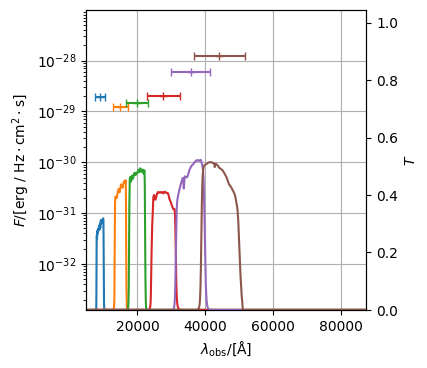

In [6]:
gal.photo_fnu["total_attenuated"].plot_photometry(show=True)

(<Figure size 350x500 with 2 Axes>,
 <Axes: xlabel='$\\lambda_\\mathrm{obs}/[\\mathrm{\\AA}]$', ylabel='$F/[\\mathrm{\\rm{erg} \\ / \\ \\rm{Hz \\cdot \\rm{cm}^{2} \\cdot \\rm{s}}}]$'>)

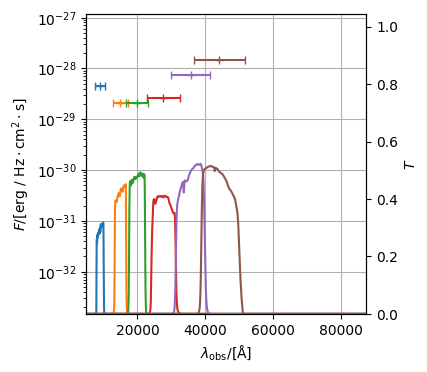

In [7]:
gal.photo_fnu["total_intrinsic"].plot_photometry(show=True)

(<Figure size 350x500 with 2 Axes>,
 <Axes: xlabel='$\\lambda_\\mathrm{obs}/[\\mathrm{\\AA}]$', ylabel='$F/[\\mathrm{\\rm{erg} \\ / \\ \\rm{Hz \\cdot \\rm{cm}^{2} \\cdot \\rm{s}}}]$'>)

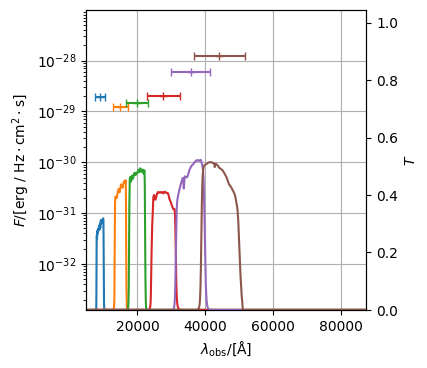

In [8]:
gal.photo_fnu["total"].plot_photometry(show=True)

## Calculating light radii

Once we have photometry we can calculate the radius enclosing a given fraction of the light for a component. Here we'll calculate the half light radius for both the intrinsic emission and the total emission in "F444W" in terms of luminosity, but before we can do that we need to get the particle spectra and call ``get_particle_photo_lnu`` to first calculate the per particle photometry (above we used the galaxy level methods to calculate integrated spectra).

In [9]:
# Get the particle spectra
pc_model.set_per_particle(True)
gal.stars.get_spectra(pc_model)

# Get the particle photometry
gal.stars.get_particle_photo_lnu(filters)

int_r50 = gal.stars.get_half_luminosity_radius(
    "intrinsic", "JWST/NIRCam.F444W"
)
tot_r50 = gal.stars.get_half_luminosity_radius(
    "stellar_total", "JWST/NIRCam.F444W"
)
print(int_r50, tot_r50)

0.014462340375810564 Mpc 0.014463169048045336 Mpc


Similarly to the "attr" radii we can compute for any particle component, we can also compute the radius enclosing any fraction of the light for any particle component. 

In [10]:
int_r20 = gal.stars.get_luminosity_radius(
    "intrinsic", "JWST/NIRCam.F444W", frac=0.2
)
tot_r20 = gal.stars.get_luminosity_radius(
    "stellar_total", "JWST/NIRCam.F444W", frac=0.2
)
int_r80 = gal.stars.get_luminosity_radius(
    "intrinsic", "JWST/NIRCam.F444W", frac=0.8
)
tot_r80 = gal.stars.get_luminosity_radius(
    "stellar_total", "JWST/NIRCam.F444W", frac=0.8
)
print(int_r20, int_r80, tot_r20, tot_r80)

0.009963902187409127 Mpc 0.021207342599690156 Mpc 0.009953317178982051 Mpc 0.02121105251044334 Mpc
